In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [7]:
from sklearn.linear_model  import LinearRegression
from sklearn.svm import SVR

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler, PowerTransformer, QuantileTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score as r2
from sklearn.impute import SimpleImputer
import seaborn as sns
from sklearn.model_selection import GridSearchCV

from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import make_scorer


from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.model_selection import cross_val_predict,RandomizedSearchCV,validation_curve
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
#from skopt import BayesSearchCV

from hyperopt import hp, fmin, tpe, STATUS_OK, Trials,rand
from hyperopt.pyll.base import scope 

def mae(y_orig,y_pred):
    abs_error = abs(y_orig-y_pred)
    return (np.mean(abs_error) / np.mean(y_orig))*100
def rmse(y_true,y_pred):
    return (mse(y_true,y_pred))**0.5
from sklearn.model_selection import cross_validate

import warnings
warnings.simplefilter("ignore")
import xgboost as  xgb



In [3]:
df = pd.read_excel('DATA.xlsx',dtype=np.longfloat)
imputer = SimpleImputer(missing_values = np.nan, strategy ='mean')
df = imputer.fit_transform(df)
X = df[:,:-1]
y = df[:,9]

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.10,random_state=22)
X_train,X_val,y_train,y_val = train_test_split(X_train,y_train,test_size=0.10,random_state=22)

scaler = StandardScaler()
X_train_sca = scaler.fit_transform(X_train)
X_val_sca = scaler.transform(X_val)
X_test_sca = scaler.transform(X_test)


In [4]:
print("Size of Training = ",y_train.shape)
print("Size of Validation",y_val.shape)
print("Size of Testing",y_test.shape)

Size of Training =  (11241,)
Size of Validation (1250,)
Size of Testing (1388,)


In [44]:
model = xgb.XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8,reg_alpha=0.2,reg_lambda=0.3)
model.fit(X_train_sca,y_train)
print("Initial Model")

print("---------------------------------------------")
print("Training Score")
print("R2 -> ",r2(y_train,model.predict(X_train_sca)))
print("MSE -> ",mse(y_train,model.predict(X_train_sca)))
print("RMSE -> ",rmse(y_train,model.predict(X_train_sca)))
print("MAE -> ",mae(y_train,model.predict(X_train_sca)))


print("---------------------------------------------")
print("Validation Score")
print("R2 -> ",r2(y_val,model.predict(X_val_sca)))
print("MSE -> ",mse(y_val,model.predict(X_val_sca)))
print("RMSE -> ",rmse(y_val,model.predict(X_val_sca)))
print("MAE -> ",mae(y_val,model.predict(X_val_sca)))


print("---------------------------------------------")
print("Test Score")
print("R2 -> ",r2(y_test,model.predict(X_test_sca)))
print("MSE -> ",mse(y_test,model.predict(X_test_sca)))
print("RMSE -> ",rmse(y_test,model.predict(X_test_sca)))
print("MAE -> ",mae(y_test,model.predict(X_test_sca)))

Initial Model
---------------------------------------------
Training Score
R2 ->  0.9985136510384914
MSE ->  0.016596985843030588
RMSE ->  0.12882928953863942
MAE ->  1.1823395937507573
---------------------------------------------
Validation Score
R2 ->  0.9113710184404635
MSE ->  1.0181542002121122
RMSE ->  1.0090362729912696
MAE ->  8.847569929917857
---------------------------------------------
Test Score
R2 ->  0.9069963151875835
MSE ->  0.9612979890869359
RMSE ->  0.9804580506512942
MAE ->  8.758787208643394


## Tuning

In [6]:
MSE = make_scorer(mse)
MAEP = make_scorer(mae)
RMSE = make_scorer(rmse)
scoring = {'R2': 'r2', 'MSE': MSE,'RMSE':RMSE,'MAEP':MAEP}
cv = KFold(n_splits=6,random_state=19,shuffle=True)

In [61]:
n_evals = 100
space = {'n_estimators': hp.choice('n_estimators',[10,50,70,90,100,120,150,170,200]),
         'max_depth': scope.int (hp.quniform('max_depth', 1,5,1)),
         'reg_alpha':hp.uniform('reg_alpha',0.0001,0.99999),
         'reg_lambda':hp.uniform('reg_lambda',0.0001,0.99999),
         'eta':hp.choice('eta',[0.001,0.01,0.1,0.2]),
         'subsample':hp.choice('subsample',[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]),
         'colsample_bytree':hp.choice('colsample_bytree',[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])
         
         
         
         
    }
def objective(space):
    
    
    model = xgb.XGBRegressor(n_estimators=space['n_estimators'], max_depth=space['max_depth'], eta=space['eta'], subsample=space['subsample'], colsample_bytree=space['colsample_bytree'],reg_alpha=space['reg_alpha'],reg_lambda=space['reg_lambda'],random_state=22)
    model.fit(X_train_sca,y_train)
    cv = RepeatedKFold(n_splits=5, random_state=1)
    scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
    scores = np.absolute(scores)
    
    y_val_pred = model.predict(X_val_sca)
    MSE = scores.mean()

    # We aim to maximize accuracy, therefore we return it as a negative value
    return {'loss': MSE, 'status': STATUS_OK }
    
trials = Trials()
best = fmin(fn= objective,
            space= space,
            algo= tpe.suggest,
            trials= trials,
               max_evals=n_evals)
best

100%|██████████| 100/100 [1:01:17<00:00, 36.77s/trial, best loss: 0.882078942298185]


{'colsample_bytree': 8,
 'eta': 3,
 'max_depth': 5.0,
 'n_estimators': 6,
 'reg_alpha': 0.09394412432543492,
 'reg_lambda': 0.2023173545415347,
 'subsample': 7}

In [67]:
# Final Model

In [66]:
model = xgb.XGBRegressor(n_estimators=110, max_depth=4, eta=0.2, subsample=0.7, colsample_bytree=0.9,reg_alpha=0.09,reg_lambda=0.202)
model.fit(X_train_sca,y_train)
print("Initial Model")

print("---------------------------------------------")
print("Training Score")
print("R2 -> ",r2(y_train,model.predict(X_train_sca)))
print("MSE -> ",mse(y_train,model.predict(X_train_sca)))
print("RMSE -> ",rmse(y_train,model.predict(X_train_sca)))
print("MAE -> ",mae(y_train,model.predict(X_train_sca)))


print("---------------------------------------------")
print("Validation Score")
print("R2 -> ",r2(y_val,model.predict(X_val_sca)))
print("MSE -> ",mse(y_val,model.predict(X_val_sca)))
print("RMSE -> ",rmse(y_val,model.predict(X_val_sca)))
print("MAE -> ",mae(y_val,model.predict(X_val_sca)))


print("---------------------------------------------")
print("Test Score")
print("R2 -> ",r2(y_test,model.predict(X_test_sca)))
print("MSE -> ",mse(y_test,model.predict(X_test_sca)))
print("RMSE -> ",rmse(y_test,model.predict(X_test_sca)))
print("MAE -> ",mae(y_test,model.predict(X_test_sca)))

Initial Model
---------------------------------------------
Training Score
R2 ->  0.8799395360684582
MSE ->  1.3406285278775496
RMSE ->  1.157855141145709
MAE ->  10.1316140043685
---------------------------------------------
Validation Score
R2 ->  0.8419650664009871
MSE ->  1.8154776078069932
RMSE ->  1.3473966037536955
MAE ->  11.803008982687857
---------------------------------------------
Test Score
R2 ->  0.8303632740619372
MSE ->  1.7533869098676875
RMSE ->  1.3241551683498756
MAE ->  11.5584335985262


In [11]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(model, X, y, scoring=MSE, cv=cv, n_jobs=-1)
scores = absolute(scores)

In [18]:
model = xgb.XGBRegressor(n_estimators=100)
model.fit(X_train_sca,y_train)
print("Initial Model")

print("---------------------------------------------")
print("Training Score")
print("R2 -> ",r2(y_train,model.predict(X_train_sca)))
print("MSE -> ",mse(y_train,model.predict(X_train_sca)))
print("RMSE -> ",rmse(y_train,model.predict(X_train_sca)))
print("MAE -> ",mae(y_train,model.predict(X_train_sca)))


print("---------------------------------------------")
print("Validation Score")
print("R2 -> ",r2(y_val,model.predict(X_val_sca)))
print("MSE -> ",mse(y_val,model.predict(X_val_sca)))
print("RMSE -> ",rmse(y_val,model.predict(X_val_sca)))
print("MAE -> ",mae(y_val,model.predict(X_val_sca)))


print("---------------------------------------------")
print("Test Score")
print("R2 -> ",r2(y_test,model.predict(X_test_sca)))
print("MSE -> ",mse(y_test,model.predict(X_test_sca)))
print("RMSE -> ",rmse(y_test,model.predict(X_test_sca)))
print("MAE -> ",mae(y_test,model.predict(X_test_sca)))

Initial Model
---------------------------------------------
Training Score
R2 ->  0.9557301709008491
MSE ->  0.49432922271919777
RMSE ->  0.7030855017131258
MAE ->  6.15208869061091
---------------------------------------------
Validation Score
R2 ->  0.8760229740476336
MSE ->  1.4242263363752476
RMSE ->  1.193409542602726
MAE ->  10.402113678909302
---------------------------------------------
Test Score
R2 ->  0.8736971372296217
MSE ->  1.3054825541802442
RMSE ->  1.1425771545853016
MAE ->  10.082606935774683


In [34]:
train = np.zeros(40)
val = np.zeros(40)
test = np.zeros(40)
x_axis = np.arange(10,401,10)
j=0
for i in range(10,401,10):
    
    model = xgb.XGBRegressor(n_estimators=i)
    model.fit(X_train_sca,y_train)
    train[j] = r2(y_train,model.predict(X_train_sca))
    val[j] = r2(y_val,model.predict(X_val_sca))
    test[j] = r2(y_test,model.predict(X_test_sca))
    j=j+1




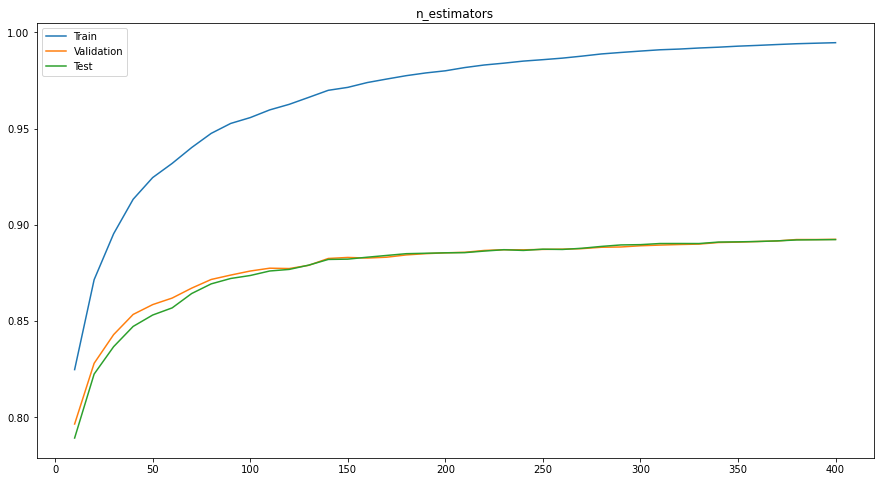

In [36]:
plt.figure(figsize=(15,8))
plt.title("n_estimators")
plt.plot(x_axis,train,label = "Train")
plt.plot(x_axis,val,label = "Validation")
plt.plot(x_axis,test,label = "Test")
plt.legend()
plt.show()

In [41]:
#Max Depth
train = np.zeros(25)
val = np.zeros(25)
test = np.zeros(25)
x_axis = np.arange(1,51,2)
j=0
for i in range(1,51,2):
    
    model = xgb.XGBRegressor(n_estimators=200,max_depth=i)
    model.fit(X_train_sca,y_train)
    train[j] = r2(y_train,model.predict(X_train_sca))
    val[j] = r2(y_val,model.predict(X_val_sca))
    test[j] = r2(y_test,model.predict(X_test_sca))
    j=j+1





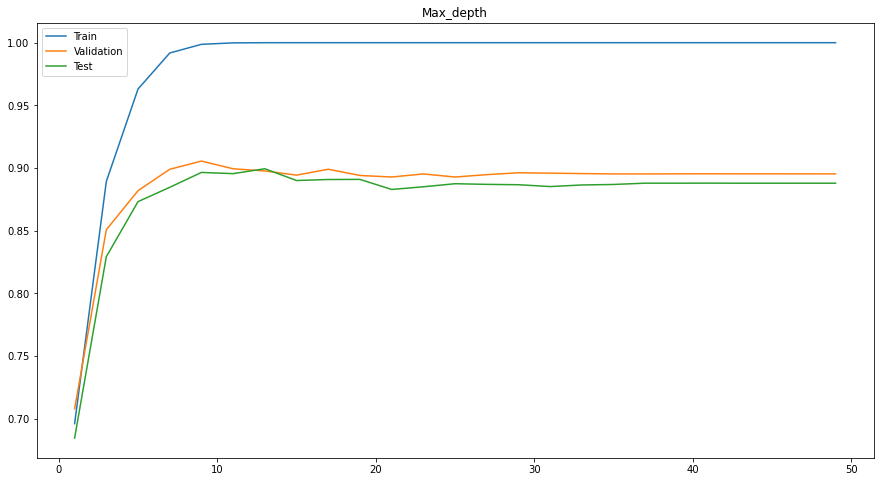

In [42]:
plt.figure(figsize=(15,8))
plt.title("Max_depth")
plt.plot(x_axis,train,label = "Train")
plt.plot(x_axis,val,label = "Validation")
plt.plot(x_axis,test,label = "Test")
plt.legend()
plt.show()

In [48]:
model = xgb.XGBRegressor(n_estimators=100,max_depth=4)
model.fit(X_train_sca,y_train)
print("Initial Model")

print("---------------------------------------------")
print("Training Score")
print("R2 -> ",r2(y_train,model.predict(X_train_sca)))
print("MSE -> ",mse(y_train,model.predict(X_train_sca)))
print("RMSE -> ",rmse(y_train,model.predict(X_train_sca)))
print("MAE -> ",mae(y_train,model.predict(X_train_sca)))


print("---------------------------------------------")
print("Validation Score")
print("R2 -> ",r2(y_val,model.predict(X_val_sca)))
print("MSE -> ",mse(y_val,model.predict(X_val_sca)))
print("RMSE -> ",rmse(y_val,model.predict(X_val_sca)))
print("MAE -> ",mae(y_val,model.predict(X_val_sca)))


print("---------------------------------------------")
print("Test Score")
print("R2 -> ",r2(y_test,model.predict(X_test_sca)))
print("MSE -> ",mse(y_test,model.predict(X_test_sca)))
print("RMSE -> ",rmse(y_test,model.predict(X_test_sca)))
print("MAE -> ",mae(y_test,model.predict(X_test_sca)))

Initial Model
---------------------------------------------
Training Score
R2 ->  0.8969694398774843
MSE ->  1.1504678860995114
RMSE ->  1.0725986603103286
MAE ->  9.391502114953248
---------------------------------------------
Validation Score
R2 ->  0.8540714999073742
MSE ->  1.6764010223919104
RMSE ->  1.2947590595905905
MAE ->  11.453817348791219
---------------------------------------------
Test Score
R2 ->  0.8393111466517765
MSE ->  1.660900553605917
RMSE ->  1.2887593078639303
MAE ->  11.37025512519602


In [54]:
#Subsample
train = np.zeros(20)
val = np.zeros(20)
test = np.zeros(20)
x_axis = np.arange(0.05,1.01,0.05)
j=0
a=0.05
for i in range(0,20):
    
    model = xgb.XGBRegressor(n_estimators=200,max_depth=4,subsample=a)
    model.fit(X_train_sca,y_train)
    train[j] = r2(y_train,model.predict(X_train_sca))
    val[j] = r2(y_val,model.predict(X_val_sca))
    test[j] = r2(y_test,model.predict(X_test_sca))
    j=j+1
    a=a+0.05





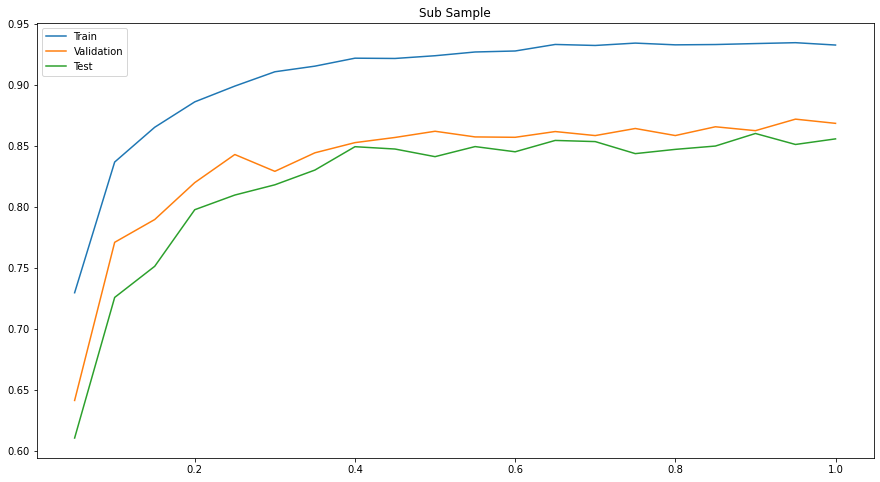

In [56]:
plt.figure(figsize=(15,8))
plt.title("Sub Sample")
plt.plot(x_axis,train,label = "Train")
plt.plot(x_axis,val,label = "Validation")
plt.plot(x_axis,test,label = "Test")
plt.legend()
plt.show()

In [57]:
# colsample_bytree
train = np.zeros(20)
val = np.zeros(20)
test = np.zeros(20)
x_axis = np.arange(0.05,1.01,0.05)
j=0
a=0.05
for i in range(0,20):
    
    model = xgb.XGBRegressor(n_estimators=200,max_depth=4,subsample=0.4,colsample_bytree=a)
    model.fit(X_train_sca,y_train)
    train[j] = r2(y_train,model.predict(X_train_sca))
    val[j] = r2(y_val,model.predict(X_val_sca))
    test[j] = r2(y_test,model.predict(X_test_sca))
    j=j+1
    a=a+0.05

    




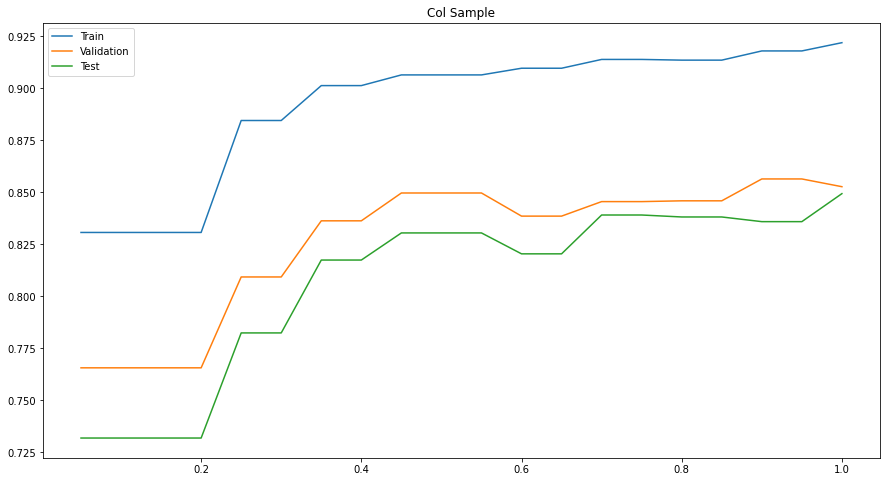

In [58]:
plt.figure(figsize=(15,8))
plt.title("Col Sample")
plt.plot(x_axis,train,label = "Train")
plt.plot(x_axis,val,label = "Validation")
plt.plot(x_axis,test,label = "Test")
plt.legend()
plt.show()